# ПРОЕКТ "ТЕЛЕКОМ"

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Цель проекта - разработать модель, прогнозирующую факт ухода клиента. 
Задачи проекта представлены в плане ниже.

ПЛАН РАБОТЫ НАД ПРОЕКТОМ:
1. Загрузка данных 
    - загрузка данных, вывод информации по предоставленным файлам;
    - изучние данных, форматов данных, наличия пропусков и повторов;
    - приведение названий столбцов к змеиному регистру;
    - объединение данных в общую таблицу для последующего обучения модели;
    - выделение признака окончания использования услуг (1 - отказался, 0 - остался)
2. EDA (исследовательский анализ данных)
    - исследование баланса классов;
    - исследование влияния длительности использования услуг на факт отказа от услуг;
    - исследования влияния различных признаков на факт отказа от услуг, введение новых признаков, которые могли бы быть значимы.
3. Подготовка данных 
    - выполнение кодирования категориальных признаков;
    - выполнение ресемплирования данных при наличии дисбаланса классов;
    - выполнение масштабирования признаков (при необходимости).
4. Моделирование 
    - выбор возможных вариантов моделей (логистическая регрессия, случайный лес, catboost и др.)
    - обучение различных вариантов моделей, выбор наилучшей на основании метрики AUC-ROC;
    - корректировка гиперпараметров наилучшей модели с целью достижения достаточного размера метрики (0,88)
5. Вывод
    - краткое описание результатов работы;
    - описание инсайтов, обнаруженных в процессе исследовательского анализа данных;
    - описание исследованных моделей, описание наилучше модели и результат рассчитанной метрики.

In [3]:
#импорт библиотек
import pandas as pd
import plotly as plt
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', 300)
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns 
import phik
from phik.report import plot_correlation_matrix

## 1 ЗАГРУЗКА ДАННЫХ

Произведем загрузку данных и их предобработку

In [4]:
#загрузка данных:

df_contract = pd.read_csv('D:/DATA/contract.csv') #Информация по заключенным договорам
df_personal = pd.read_csv('D:/DATA/personal.csv') #Информация по пользователям
df_internet = pd.read_csv('D:/DATA/internet.csv') #Информация по клиентам, которые пользуются интернетом
df_phone = pd.read_csv('D:/DATA/phone.csv') #Информация по клиентам, которые используют телефонную связь


In [5]:
#вывод общей информации по загруженным данным:

display(df_contract.head())
df_contract.info()

display(df_personal.head())
df_personal.info()

display(df_internet.head())
df_internet.info()

display(df_phone.head())
df_phone.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [6]:
#выведем все уникальные значения таблицы с договорами:
for name in df_contract.columns:
    print (name, df_contract[name].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-

In [7]:
#выведем все уникальные значения таблицы с информацией о пользователях:
for name in df_personal.columns:
    print (name, df_personal[name].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']


In [8]:
#выведем все уникальные значения таблицы с пользователями интернета:
for name in df_internet.columns:
    print (name, df_internet[name].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


In [9]:
#выведем все уникальные значения таблицы с пользователями телефонии:
for name in df_phone.columns:
    print (name, df_phone[name].unique())

customerID ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
MultipleLines ['No' 'Yes']


По всей видимости, данные прошли определенную стадию предобработки - пропуски отсутствуют. Значения, встречающиеся внутри столбцов предварительно вопросов не вызывают. Изучим данные более внимательно. Приведем названия к змеиному регистру, а заодно разберемся с тем, что означает каждый столбец.

In [10]:
df_contract = df_contract.rename(
    columns={
        'customerID': 'customer_id', #код клиента - уникальный идентификатор
        'BeginDate': 'begin_date', #судя по названию, это дата начала использования услуг
        'EndDate': 'end_date', #дата окончания использования услуг
        'Type': 'type', #тип договора (на какую длительность он заключается)
        'PaperlessBilling': 'paperless_billing', #факт выставления чека на почту клиента или как-то иначе
        'PaymentMethod': 'payment_method', #способ оплаты
        'MonthlyCharges': 'monthly_charges', #месячные траты
        'TotalCharges': 'total_charges' #общие траты с момента начала использования услуг   
    }
)

df_personal = df_personal.rename(
    columns={
        'customerID': 'customer_id', #код клиента - уникальный идентификатор
        'SeniorCitizen': 'senior_citizen ', #Пенсионер? 0 и 1?
        'Partner': 'partner', #есть пара или нет
        'Dependents': 'dependents' #есть иждивенцы (дети) или нет
        
    }
)

df_internet = df_internet.rename(
    columns={
        'customerID': 'customer_id', #код клиента - уникальный идентификатор
        'InternetService': 'internet_service',
        'OnlineSecurity': 'online_security', 
        'OnlineBackup': 'online_backup',
        'DeviceProtection': 'device_protection',
        'TechSupport': 'tech_support',
        'StreamingTV': 'streaming_TV',
        'StreamingMovies': 'streaming_movies'
        
    }
)

df_phone = df_phone.rename(
    columns={
        'customerID': 'customer_id', #код клиента - уникальный идентификатор
        'MultipleLines': 'multiple_lines',
               
    }
)

In [11]:
#проверим нет ли в таблице клиентов, которые вернулись (они должны встретиться несколько раз)
df_contract['customer_id'].nunique()
#все пользователи уникальные (7043 соответствует количеству записей в таблице), никто не вернулся.

7043

Каждая из таблиц содержит информацию по одним и тем же пользователям, соответственно, для дальнейшего анализа разумно свести данные в одну таблицу:

In [12]:
df = df_contract.merge(df_personal, on='customer_id', how='left')
df = df.merge(df_internet, on='customer_id', how='left')
df = df.merge(df_phone, on='customer_id', how='left')

In [13]:
#проверим пустые ячейки после объединения:
print (df.isna().sum())
#не все пользуются интернетом, как и телефоном. Заменим пустые ячейки на 'No'
df = df.fillna('No')

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_TV         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


In [14]:
#переведем числовые данные в другой формат:
df['monthly_charges'] = df['monthly_charges'].astype('float')
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df['total_charges'] = df['total_charges'].astype(float)

In [15]:
#проверим, что из себя представляют данные теперь:
df = df.fillna(0)

Сводная таблица готова. Продолжим подготовку данных для дальнейшего исследования.

In [16]:
#добавим признак, отражающий факт того, ушёл ли клиент. 0 - остался, 1 - ушёл
def exited(row):
    if row['end_date'] == 'No':
        return(0)
    return(1)

df['exited'] = df.apply(exited, axis=1)


## 2 ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

Оценим балланс классов

0    0.73463
1    0.26537
Name: exited, dtype: float64


<AxesSubplot:>

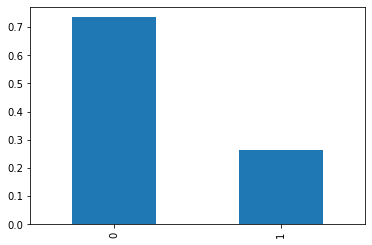

In [17]:
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Отток клиентов составляет порядка 26,5%. По всей видимости, понадобится балансировка классов

Представленные данные содержат далеко не все признаки, которые могли бы оказывать влияние на предпочтения клиентов. Разумно предположиить, что на то, откажется клиент или нет от услуг, будет влиять длительность пользования услугами компании.

In [18]:
#введем новый признак - количество дней, которое клиент пользуется услугами компании:
df['begin_date'] = pd.to_datetime(df['begin_date'])
def delta(row):

    
    
    date_1 = row['begin_date']
    if row['end_date'] == 'No':
        date_2 = datetime(2020, 2, 1)
    else:
        date_2 = pd.to_datetime(row['end_date'])
    delta = date_2 - date_1
    return int(delta.days)

df['delta'] = df.apply(delta, axis=1)


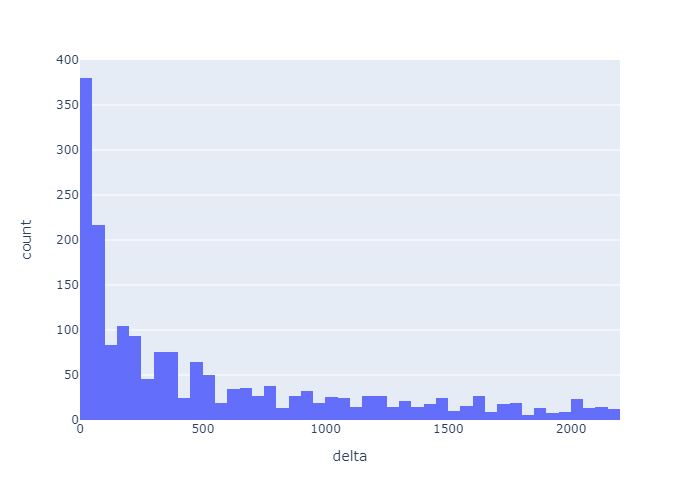

In [19]:
#Построим гистограмму ушедших в зависимости от того, как долго они были клиентами:

fig = px.histogram(df.query('exited == 1'), x="delta", nbins=80)
fig.show('png')

В соответствии с теорией случайных процессов, интервалы времени распределены по показательному закону. Чаще всего отказываются от услуг компании те, кто пользовался услугами компании короткий срок. Соответственно, delta для модели будет крайне актуальным фактором. 

In [20]:
#возможно, на отток клиентов будет влиять "вовлеченность" в работу телекома. 
#добавим признак, в котором будет указано количество услуг, используемых абонентом. Услуги:
# internet_service   
# online_security    
# online_backup      
# device_protection  
# tech_support       
# streaming_TV       
# streaming_movies   
# multiple_lines     

def service_count(row):
    count = 0
    if row['internet_service'] != 'No':
        count +=1
    if row['online_security'] != 'No':
        count +=1
    if row['online_backup'] != 'No':
        count +=1
    if row['device_protection'] != 'No':
        count +=1
    if row['tech_support'] != 'No':
        count +=1
    if row['streaming_TV'] != 'No':
        count +=1
    if row['streaming_movies'] != 'No':
        count +=1
    if row['multiple_lines'] != 'No':
        count +=1
    
    return count

In [21]:
df['service_count'] = df.apply(service_count, axis=1)


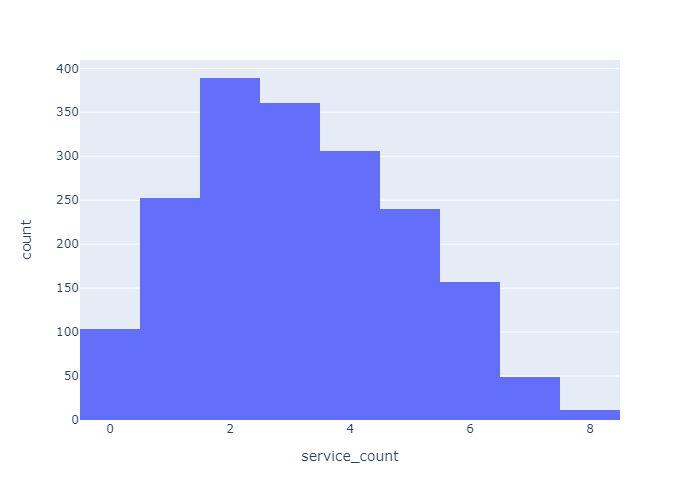

In [22]:
#Построим гистограмму ушедших в зависимости от того, сколько подключено сервисов:

fig = px.histogram(df.query('exited == 1'), x="service_count", nbins=9)
fig.show('png')

Очертания гистограммы дают возможность предположить, что количество сервисов имеет гамма-распределение либо распределение, приближенное к нормальному. Клиенты без сервисов и с большим количеством сервисов уходят заметно реже. Скорее всего, этот признак важен

## 3 ПОДГОТОВКА ДАННЫХ

Опираясь на анализ, проведенный выше, подготовим фрейм с признаками и целевым признаком, а затем произведем их обработку

In [23]:
#избавимся от незначащих признаков:
features = df.drop(['customer_id', 'begin_date', 'end_date', 'exited'], axis=1)
target = df['exited']

In [24]:
#Кодирование категориальных признаков
features = pd.get_dummies (features, drop_first=True)

In [25]:
#для получившегося фрейма признаков произведем анализ мультиколлениарности
interval_cols = ['monthly_charges', 'total_charges', 'delta', 'service_count']
phik_overview = features.phik_matrix(interval_cols=interval_cols)

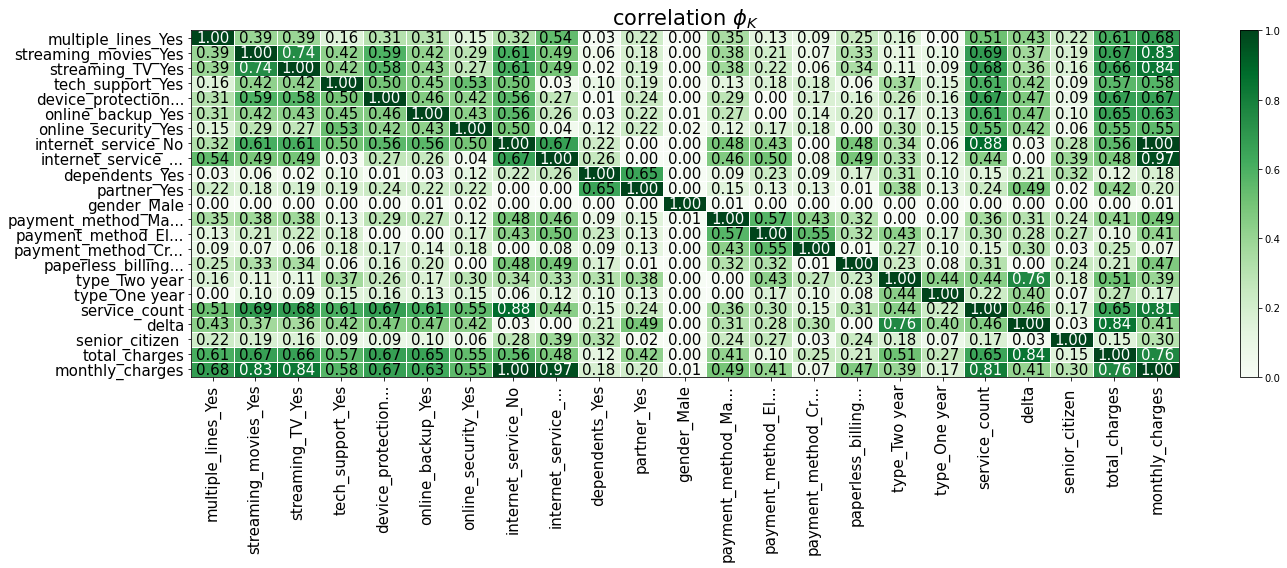

In [26]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 8))
plt.tight_layout()

Явная коллениарность между признаками отсутствует, соответственно, корректировать таблицу не требуется.

In [27]:
#Разобьем выборку на обучающую и тестовую:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25 , random_state=290822)

In [28]:
#масштабируем признаки:
scaler = StandardScaler()
numeric = ['monthly_charges', 'total_charges', 'delta', 'service_count']

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [29]:
#Обучим пробную модель

#Обучение модели, ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ:

model = LogisticRegression(random_state=290822, solver='liblinear')
model.fit(features_train, target_train)

predicted_test = model.predict(features_test)
print (f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score (target_test, probabilities_one_test) 
print(auc_roc)

0.5839243498817968
0.83757878366211


В качестве целевого признака заказчиком установлена метрика AUC_ROC (0,88). В целом, результат AUC_ROC приближается к необходимому уровню (0,88). Выполним ресемплирование данных, чтобы оценить, позволит ли это увеличить метрику

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=290822)
    
    return features_upsampled, target_upsampled

In [31]:
#Увеличим выборку:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [32]:
model = LogisticRegression(random_state=290822, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print (f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score (target_test, probabilities_one_test) 
print(auc_roc)

0.6248969497114591
0.8379471228615862


Увеличение оказалось крайне незначительным. Попробуем выборку наоборот уменьшить

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=290822)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=290822)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=290822)
    
    return features_downsampled, target_downsampled

In [34]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.33)

In [35]:
#Логистическая регрессия 

model = LogisticRegression(random_state=290822, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print (f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score (target_test, probabilities_one_test) 
print(auc_roc)

0.6188925081433225
0.8383432921339118


Увеличение аналогично оказалось крайне незначительным.
Обработка данных, которая могла бы позволить увеличить качество модели выполнена. Обучение моделей предлагается выполнять на исходной выборке без сэмплирования. Если лучшая модель не сможет достичь этого показателя, то попробуем ещё раз использовать семплирование. 

## 4 МОДЕЛИРОВАНИЕ

Исследуем следующие модели: логистическая регрессия, случайное дерево, случайный лес решений, catboost. Гиперпараметры моделей зададим произвольно, основываясь на эмпирическом опыте. В последствии гиперпараметры нужно будет скорректировать.

In [36]:
#Логистическая регрессия
model = LogisticRegression(random_state=290822, solver='liblinear')
scores = cross_val_score(model, features, target,scoring="roc_auc", cv=5) 
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)


Средняя оценка качества модели: 0.8426855350030438


In [37]:
#Дерево решений
model = DecisionTreeClassifier(random_state=290822)
scores = cross_val_score(model, features, target,scoring="roc_auc", cv=5) 
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.7076654061623799


In [38]:
#Cлучайный лес
model = RandomForestClassifier(random_state=290822, n_estimators=100, max_depth=12, class_weight='balanced')
scores = cross_val_score(model, features, target,scoring="roc_auc", cv=5) 
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.8544356953955706


In [39]:
#catboost
model = CatBoostClassifier(loss_function="Logloss", iterations=150, depth=12, learning_rate=.2)
scores = cross_val_score(model, features, target,scoring="roc_auc", cv=5) 
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

0:	learn: 0.5719923	total: 185ms	remaining: 27.6s
1:	learn: 0.4925312	total: 263ms	remaining: 19.5s
2:	learn: 0.4418149	total: 338ms	remaining: 16.6s
3:	learn: 0.4113726	total: 429ms	remaining: 15.6s
4:	learn: 0.3816185	total: 510ms	remaining: 14.8s
5:	learn: 0.3646745	total: 592ms	remaining: 14.2s
6:	learn: 0.3508651	total: 678ms	remaining: 13.8s
7:	learn: 0.3394784	total: 777ms	remaining: 13.8s
8:	learn: 0.3259285	total: 867ms	remaining: 13.6s
9:	learn: 0.3182212	total: 950ms	remaining: 13.3s
10:	learn: 0.3141268	total: 955ms	remaining: 12.1s
11:	learn: 0.3037020	total: 1.03s	remaining: 11.9s
12:	learn: 0.2931805	total: 1.12s	remaining: 11.8s
13:	learn: 0.2834662	total: 1.22s	remaining: 11.8s
14:	learn: 0.2827758	total: 1.22s	remaining: 11s
15:	learn: 0.2756480	total: 1.3s	remaining: 10.9s
16:	learn: 0.2706324	total: 1.38s	remaining: 10.8s
17:	learn: 0.2706065	total: 1.39s	remaining: 10.2s
18:	learn: 0.2675442	total: 1.47s	remaining: 10.1s
19:	learn: 0.2621957	total: 1.55s	remaining:

Наилучшие результаты показывает Catboost. Однако, значение метрики всё ещё недостаточное. Попробуем настроить гиперпараметры и используем семплирование.

In [40]:
#UPSAMPLING
model = CatBoostClassifier(loss_function="Logloss", iterations=100, depth=8, learning_rate=.1)
scores = cross_val_score(model, features_upsampled, target_upsampled,scoring="roc_auc", cv=3) 
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

0:	learn: 0.6368130	total: 15.2ms	remaining: 1.51s
1:	learn: 0.5969575	total: 24.5ms	remaining: 1.2s
2:	learn: 0.5690559	total: 34.5ms	remaining: 1.11s
3:	learn: 0.5453280	total: 42.4ms	remaining: 1.02s
4:	learn: 0.5244245	total: 55.1ms	remaining: 1.05s
5:	learn: 0.5063675	total: 64.8ms	remaining: 1.01s
6:	learn: 0.4948156	total: 74.7ms	remaining: 993ms
7:	learn: 0.4834827	total: 86.1ms	remaining: 990ms
8:	learn: 0.4737318	total: 97.6ms	remaining: 987ms
9:	learn: 0.4640971	total: 107ms	remaining: 966ms
10:	learn: 0.4558361	total: 118ms	remaining: 956ms
11:	learn: 0.4489310	total: 127ms	remaining: 935ms
12:	learn: 0.4431805	total: 138ms	remaining: 924ms
13:	learn: 0.4363952	total: 149ms	remaining: 915ms
14:	learn: 0.4321788	total: 158ms	remaining: 895ms
15:	learn: 0.4278933	total: 168ms	remaining: 880ms
16:	learn: 0.4250416	total: 178ms	remaining: 868ms
17:	learn: 0.4193310	total: 187ms	remaining: 850ms
18:	learn: 0.4150400	total: 196ms	remaining: 835ms
19:	learn: 0.4100587	total: 208ms

Необходимая точность достигнута. Проверим результаты на тестовой выборке, перед этим определив наилучшие гиперпараметры модели:


In [ ]:
best_model = None
best_iter = 0
best_depth = 0
best_rate = 0
best_auc = 0
for iter in range(1, 400, 50):
     for dep in range (4, 10):
        for rate in np.arange(0.01, 0.7, 0.1):
            model = CatBoostClassifier(loss_function="Logloss", iterations=iter, depth=dep, learning_rate=rate)
            model.fit(features_upsampled, target_upsampled)
            probabilities_test = model.predict_proba(features_test)
            probabilities_one_test = probabilities_test[:, 1]
            auc_roc = roc_auc_score (target_test, probabilities_one_test) 
            if auc_roc > best_auc:
                best_auc = auc_roc
                best_iter = iter
                best_depth = dep
                best_rate = rate
                

print("Лучший ROC", best_auc, "параметры:", best_iter, best_depth, best_rate)

0:	learn: 0.6883599	total: 3.79ms	remaining: 0us
0:	learn: 0.6443379	total: 3.54ms	remaining: 0us
0:	learn: 0.6073217	total: 4.23ms	remaining: 0us
0:	learn: 0.5768860	total: 3.5ms	remaining: 0us
0:	learn: 0.5524393	total: 3.42ms	remaining: 0us
0:	learn: 0.5333868	total: 3.49ms	remaining: 0us
0:	learn: 0.5190830	total: 3.66ms	remaining: 0us
0:	learn: 0.6883302	total: 3.75ms	remaining: 0us
0:	learn: 0.6440495	total: 3.76ms	remaining: 0us
0:	learn: 0.6068470	total: 4.05ms	remaining: 0us
0:	learn: 0.5762799	total: 4.25ms	remaining: 0us
0:	learn: 0.5517567	total: 3.74ms	remaining: 0us
0:	learn: 0.5326498	total: 4.04ms	remaining: 0us
0:	learn: 0.5183376	total: 3.68ms	remaining: 0us
0:	learn: 0.6881554	total: 4.7ms	remaining: 0us
0:	learn: 0.6423453	total: 4.15ms	remaining: 0us
0:	learn: 0.6038854	total: 4.21ms	remaining: 0us
0:	learn: 0.5723183	total: 4.28ms	remaining: 0us
0:	learn: 0.5470348	total: 5.37ms	remaining: 0us
0:	learn: 0.5273864	total: 4.16ms	remaining: 0us
0:	learn: 0.5126815	to

Наилучшие гиперпараметрыпараметры модели: iterations - 251, depth - 4, learning_rate - 0.2

In [ ]:

model = CatBoostClassifier(loss_function="Logloss", iterations=250, depth=4, learning_rate=.2)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print (f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score (target_test, probabilities_one_test) 
print(auc_roc)

Значние F меры составило 0,7, а значение AUC-ROC - 0,918. И то, и другое является хорошим показателем для нашей модели.

In [ ]:
#Построим график важности признаков

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')


Из графика мы видим, что наибольшее влияние на результаты работы модели оказывает параметр признак delta. Видимо, не рассчитав его на этапе исследовательского анализа данных, с моделью могли бы возникнуть проблемы.

## ВЫВОДЫ

В проекте получены следующие результаты:
1. Произведена загрузка данных, объединены таблицы, выполнен поиск пропусков и дубликатов.
2. Выполнен исследовательский анализ данных, добавлены новые признаки, такие как, например, длительность использования клиентом услуг телекома. 
3. Произведена подготовка данных к обучению методами машинного обучения: выполнено кодирование категориальных признаков, исследован эффект от ресемплирования (и оно же выполнено), произведено масштабирование колличественных признаков.  
4. Произведено моделирование с использованием различных вариантов моделей (логистическая регрессия, случайный лес, catboost и др.). Установлено, что наибольшее качество модели с точки зрения метрики AUC-ROC обеспечивает Catboost. Выполнен поиск наилучших гиперпараметров, в результате чего значение метрики AUC-ROC достигло 0,89. Также выполнен анализ выажности признаков - установлено, что наиболее важным признаком является длительность использования услуг клиентами телекома.


### ОТЧЕТ

Проект выполнен в соответствии с планом, представленным на начальном этапе. Невыполненные пункты отсутствуют, однако, появились и новые - произведена проверка мультиколлениартности признаков, а также выполнена проверка важности признаков после обучения модели. Решение задачи можно считать полным - модель обучена, адекватность модели подтверждена высокими значениями метрик.

В результате выполнения работы существенных сложностей не возникло - предоставленные данные достаточно хорошо были предобработаны изначально, ключевой признак, влияющий на уход клиентов (длительность использования услуг) тоже был достаточно быстро установлен в процессе исследовательского анализа данных. Определенную сложность вызвали поручения тимлида - пришлось освоить несколько новых навыков, которые не были изложены в основном курсе, однако это одновременно является большим плюсом - проверка мультиколлениарности и исследование важности признаков - это очень важные моменты.

Ключевыми шагами решения являются:
1) Объединение разрозненных данных в одну таблицу в правильном порядке (не теряя клиентов) и переработкой пропущенных значений.
2) Трансформация целевого признака в 0 и 1, а также выделение дополнительных признаков, которые могут оказать существенное влияние на результат, что было выполненно в рамках исследовательского анализа данных. delta и service_count (подготовленные мною признаки) оказались достаточно важными элементами модели.
3) Подготовка данных для реализации модели классификации - ресемплирование, масштабирование, преобразование категориальных признаков.
4) Выбор наилучшей модели для решения задачи классификации. В нашем случае ей оказался Catboost.
5) Выбор наилучших гиперпараметров, обеспечивающих максимизацию метрики AUC_ROC.
Выполнение этих шагов позволило получить необходимый результат. 

Итоговая модель - Catboost. При разделении выборки на тестовую и обучающую, а также при обучении различных моделей параметр random_state был принят равным 290822. Гиперпараметры итоговой модели следующие: iterations = 250, depth = 4, learning_rate = 0.2. Качество модели определяется метриками качества, а именно: значние F меры составило 0,7, а значение AUC-ROC - 0,918. И то, и другое является хорошим показателем для нашей модели. Анализ признаков показал, что наиболее значимым параметром является длительность использования услугами телекома и стоимость услуг. Это также подтверждается в исследовательском анализе данных - чаще всего компанию покидают клиенты, которые пользовались услугами не слишком долго. Соответственно, особое внимание нужно фокусировать на их удовлетворенности услугами и, возможно, предлагать им различные варианты временного уменьшения стоимости услуг.